# Análise de Dados - Atrasos de Voos

Análise de qualidade dos dados brutos da camada Bronze - 13 Gráficos.

Foco na validação da integridade e qualidade dos dados brutos considerando os principais determinantes dos atrasos de voos antes do ETL.

### Configuração do ambiente
- **Objetivo:** preparar ambiente visual e importar bibliotecas



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")

### Carga dos dados

Carregar CSVs do diretório raw.

In [2]:
df = pd.read_csv('dados_brutos.csv')
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

## Gráfico 1: Matriz de Correlação


### Objetivo

Identificar a força e a direção do relacionamento linear entre as diferentes causas de atraso e métricas operacionais, evidenciando interdependências e possíveis efeitos sistêmicos no desempenho da malha aérea.

### Ações

* Seleção das principais causas de atraso a partir da tabela `silver.airline_delays`:

  * `carrier_delay` (atraso da companhia)
  * `weather_delay` (atraso meteorológico)
  * `nas_delay` (atraso do sistema nacional de aviação – NAS)
  * `late_aircraft_delay` (efeito cascata de aeronave atrasada)
* Inclusão de métricas operacionais associadas a falhas de serviço:

  * `arr_cancelled` (voos cancelados)
  * `arr_diverted` (voos desviados)

### Saída

Heatmap quadrado de correlação, com gradação de cores do azul (correlação fraca) ao vermelho (correlação forte), exibindo numericamente os coeficientes de correlação entre causas de atraso e métricas operacionais.


### Insight Esperado

Evidência de um **efeito cascata operacional**, no qual `late_aircraft_delay` apresenta forte correlação positiva com `carrier_delay` e `nas_delay`, indicando que atrasos iniciais tendem a se propagar ao longo da malha aérea. Além disso, espera-se observar que cancelamentos e desvios possuem correlações mais moderadas, sugerindo que atuam mais como respostas a falhas operacionais severas do que como causas diretas do atraso total.


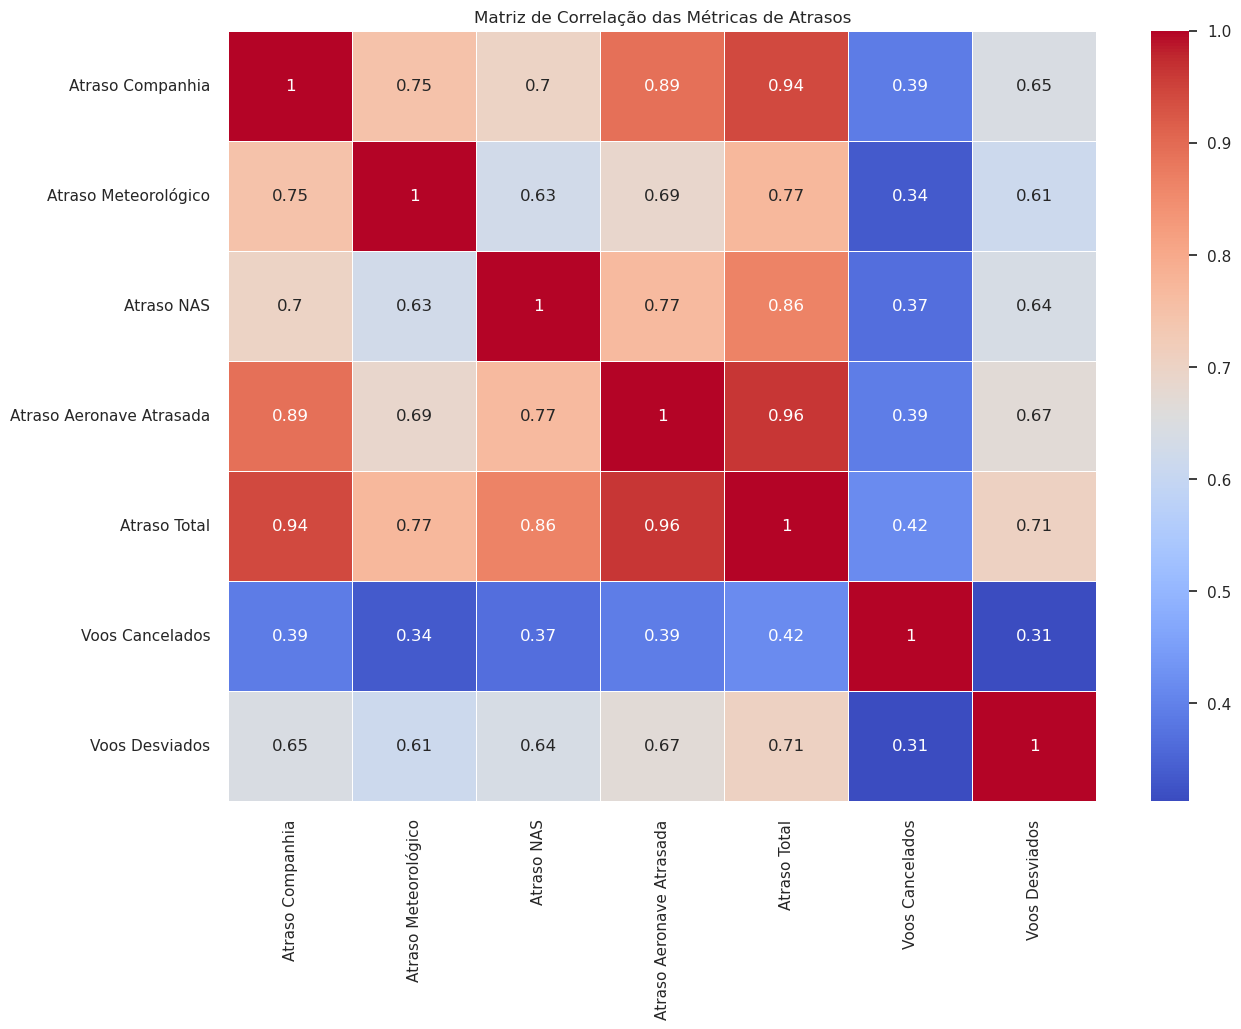

In [4]:
delay_reasons = ['carrier_delay', 'weather_delay', 'nas_delay', 'late_aircraft_delay']
df_corr = df[delay_reasons + ['arr_delay', 'arr_cancelled', 'arr_diverted']]

labels_pt = {
    'carrier_delay': 'Atraso Companhia',
    'weather_delay': 'Atraso Meteorológico',
    'nas_delay': 'Atraso NAS',
    'late_aircraft_delay': 'Atraso Aeronave Atrasada',
    'arr_delay': 'Atraso Total',
    'arr_cancelled': 'Voos Cancelados',
    'arr_diverted': 'Voos Desviados'
}

plt.figure(figsize=(14, 10))
corr_matrix = df_corr.corr()
corr_matrix = corr_matrix.rename(columns=labels_pt, index=labels_pt)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação das Métricas de Atrasos')
plt.show()

## Gráfico 2: Atraso Médio por Companhia Aérea

## Objetivo

Comparar a eficiência operacional das companhias aéreas, identificando as mais e menos pontuais.

### Ações

* Agrupar os dados da tabela `silver.airline_delays` por `carrier_name`
* Ordenar os resultados de forma decrescente pelo atraso médio

### Saída

Gráfico de barras horizontais com companhias no eixo Y e atraso médio (minutos) no eixo X.

### Insight Esperado

Identificação de companhias com problemas sistêmicos de pontualidade versus aquelas mais eficientes, permitindo avaliar o maior volume de operação implica pior desempenho.

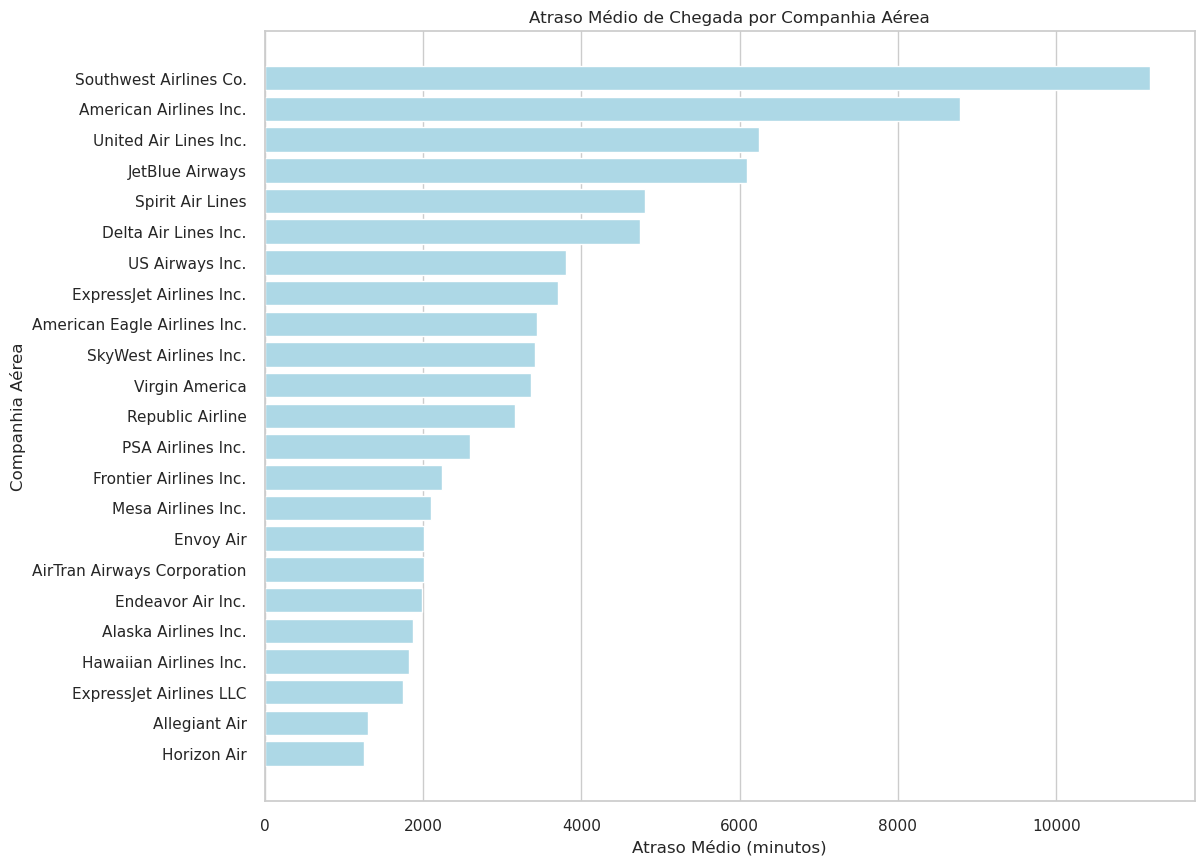

In [8]:
average_delay_per_carrier = df.groupby('carrier_name')['arr_delay'].mean().sort_values().reset_index()

plt.figure(figsize=(12, 10))
plt.barh(average_delay_per_carrier['carrier_name'], average_delay_per_carrier['arr_delay'], color='lightblue')
plt.title('Atraso Médio de Chegada por Companhia Aérea')
plt.xlabel('Atraso Médio (minutos)')
plt.ylabel('Companhia Aérea')
plt.grid(axis='y')
plt.show()

## Gráfico 3: Impacto das Condições Meteorológicas

### Objetivo

Identificar padrões sazonais críticos de atrasos causados por clima ao longo do ano.

### Ações

* Agrupar os dados por `month` (1 a 12)
* Somar `weather_ct` para obter o volume absoluto de atrasos

### Saída

Gráfico de barras verticais com meses no eixo X e volume ou tempo médio de atraso no eixo Y.

### Insight Esperado

Visualização de picos sazonais, como atrasos no inverno (nevascas) e no verão (tempestades)

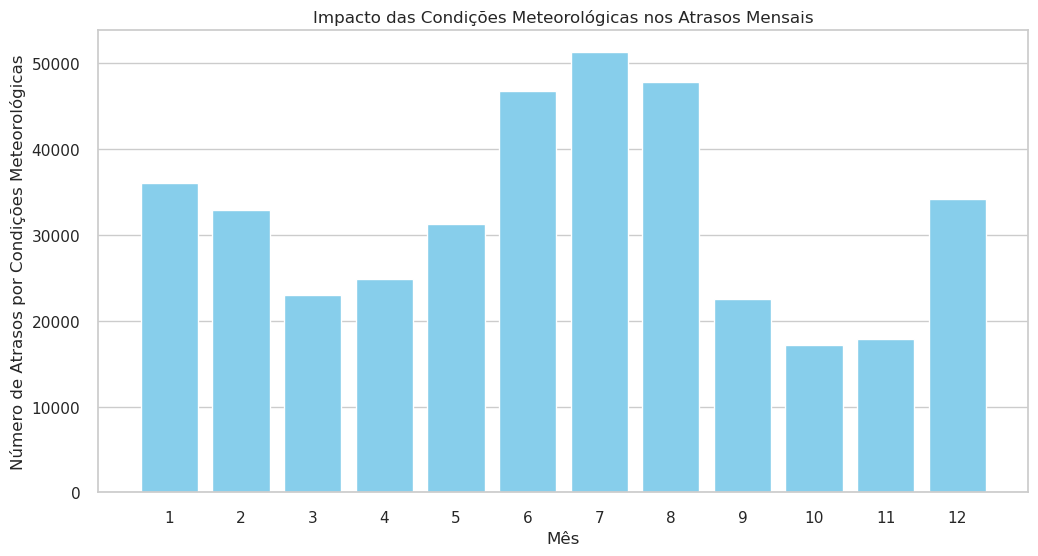

In [7]:
weather_impact = df.groupby(['month'])['weather_ct'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(weather_impact['month'], weather_impact['weather_ct'], color='skyblue')
plt.title("Impacto das Condições Meteorológicas nos Atrasos Mensais")
plt.xlabel("Mês")
plt.ylabel("Número de Atrasos por Condições Meteorológicas")
plt.xticks(range(1, 13))
plt.grid(axis='x')
plt.show()

## Gráfico 4: Sazonalidade - Atrasos Mensais por Ano


### Objetivo
Identificar por mês o número de voos atrasados em pelo menos 15 minutos, segmentado por ano, permitindo observar o que pode influenciar nos atrasos, observando datas comemorativas ou efeitos globais gerais.

### Ações
- Agrupar os dados da tabela `silver.airline_delays` por `year` e `month`

### Saída
Gráfico de linhas múltiplas (*spaghetti plot*), com:
- Eixo X: meses (Jan–Dez)
- Eixo Y: taxa de atraso ou média de atraso

### Insight Esperado
- **Padrão estrutural**: Elevação consistente das curvas em junho/julho e dezembro confirma a sazonalidade associada a férias e clima  
- **Detecção de anomalias**: O ano de 2020 deve apresentar curva significativamente abaixo das demais, refletindo o impacto da pandemia  
- **Recuperação**: Comparar a forma da curva de 2023 com 2019 para avaliar o retorno ao comportamento pré-pandemia

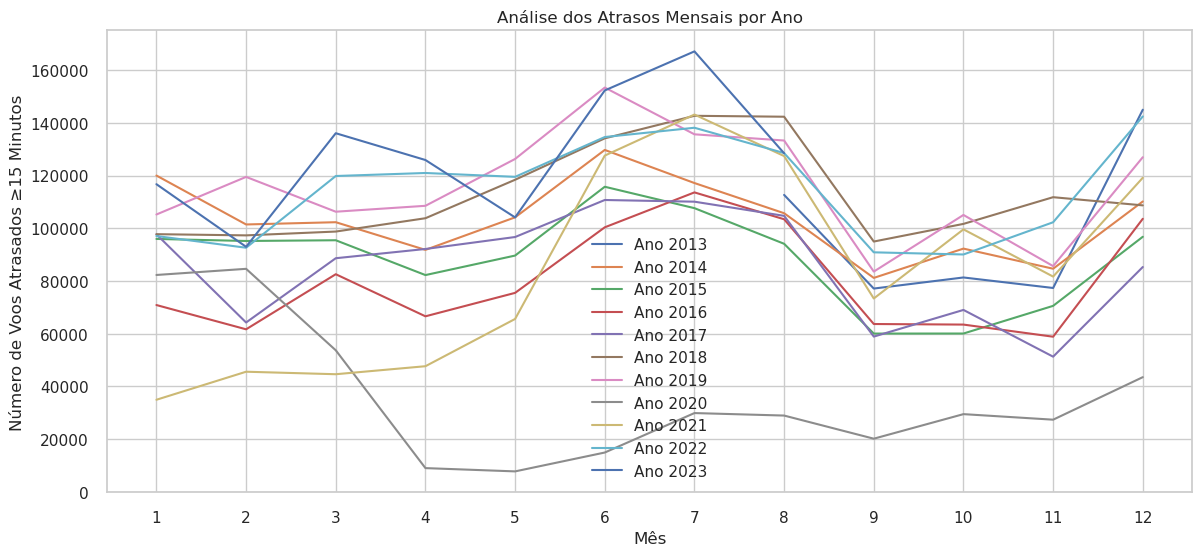

In [9]:
monthly_delays = df.groupby(['year', 'month'])['arr_del15'].sum().reset_index()
plt.figure(figsize=(14, 6))
for year in sorted(monthly_delays['year'].unique()):
    monthly_data = monthly_delays[monthly_delays['year'] == year]
    plt.plot(monthly_data['month'], monthly_data['arr_del15'], label=f'Ano {year}')
plt.title('Análise dos Atrasos Mensais por Ano')
plt.xlabel('Mês')
plt.ylabel('Número de Voos Atrasados ≥15 Minutos')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()

## Gráfico 5: Tendência de Atrasos Totais ao Longo do Tempo


### Objetivo

Monitorar a evolução do impacto absoluto dos atrasos no sistema aéreo e nos passageiros.

### Ações

* Criar uma data mensal (YYYY-MM) a partir de `year` e `month`
* Somar `arr_delay` (minutos perdidos) ou `arr_del15` (voos atrasados)

### Saída

Gráfico de linha temporal com o tempo no eixo X e o total de atrasos no eixo Y.

### Insight Esperado

Diferenciar aumentos causados apenas pelo volume de voos de períodos de crise sistêmica com crescimento real do tempo perdido pelos passageiros.

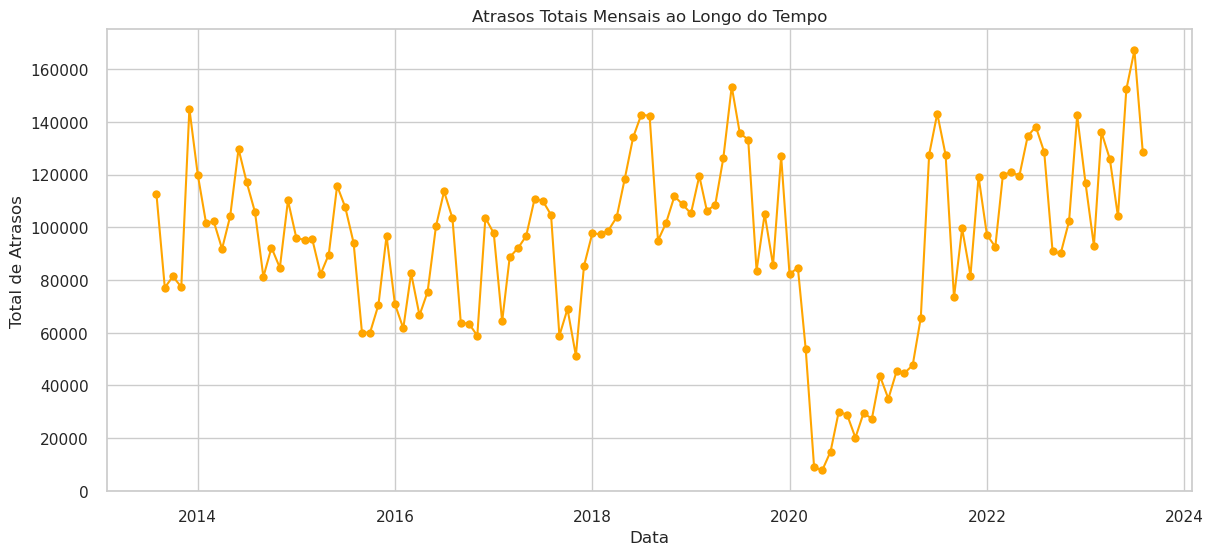

In [7]:
trend_data = df.groupby(['year', 'month'])['arr_del15'].sum().reset_index()
trend_data['date'] = pd.to_datetime(trend_data[['year', 'month']].assign(day=1))
plt.figure(figsize=(14, 6))
plt.plot(trend_data['date'], trend_data['arr_del15'], marker='o', color='orange')
plt.title('Atrasos Totais Mensais ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Total de Atrasos')
plt.grid(True)
plt.show()

## Gráfico 6: Razões dos Atrasos (Grid 2x2)

### Objetivo

Identificar quais fatores estão impulsionando a ineficiência operacional ao longo do tempo.

### Ações

* Selecionar as principais causas de atraso:

  * `carrier_delay`
  * `weather_delay`
  * `nas_delay`
  * `late_aircraft_delay`
* Agrupar os dados por `year` e `month`

### Saída

Painel de *small multiples* (grid 2x2) com gráficos de linha, compartilhando os mesmos eixos de tempo e magnitude.

### Insight Esperado

Diferenciar responsabilidades operacionais e externas, identificando padrões como problemas de gestão de frota ou gargalos estruturais do sistema aéreo.

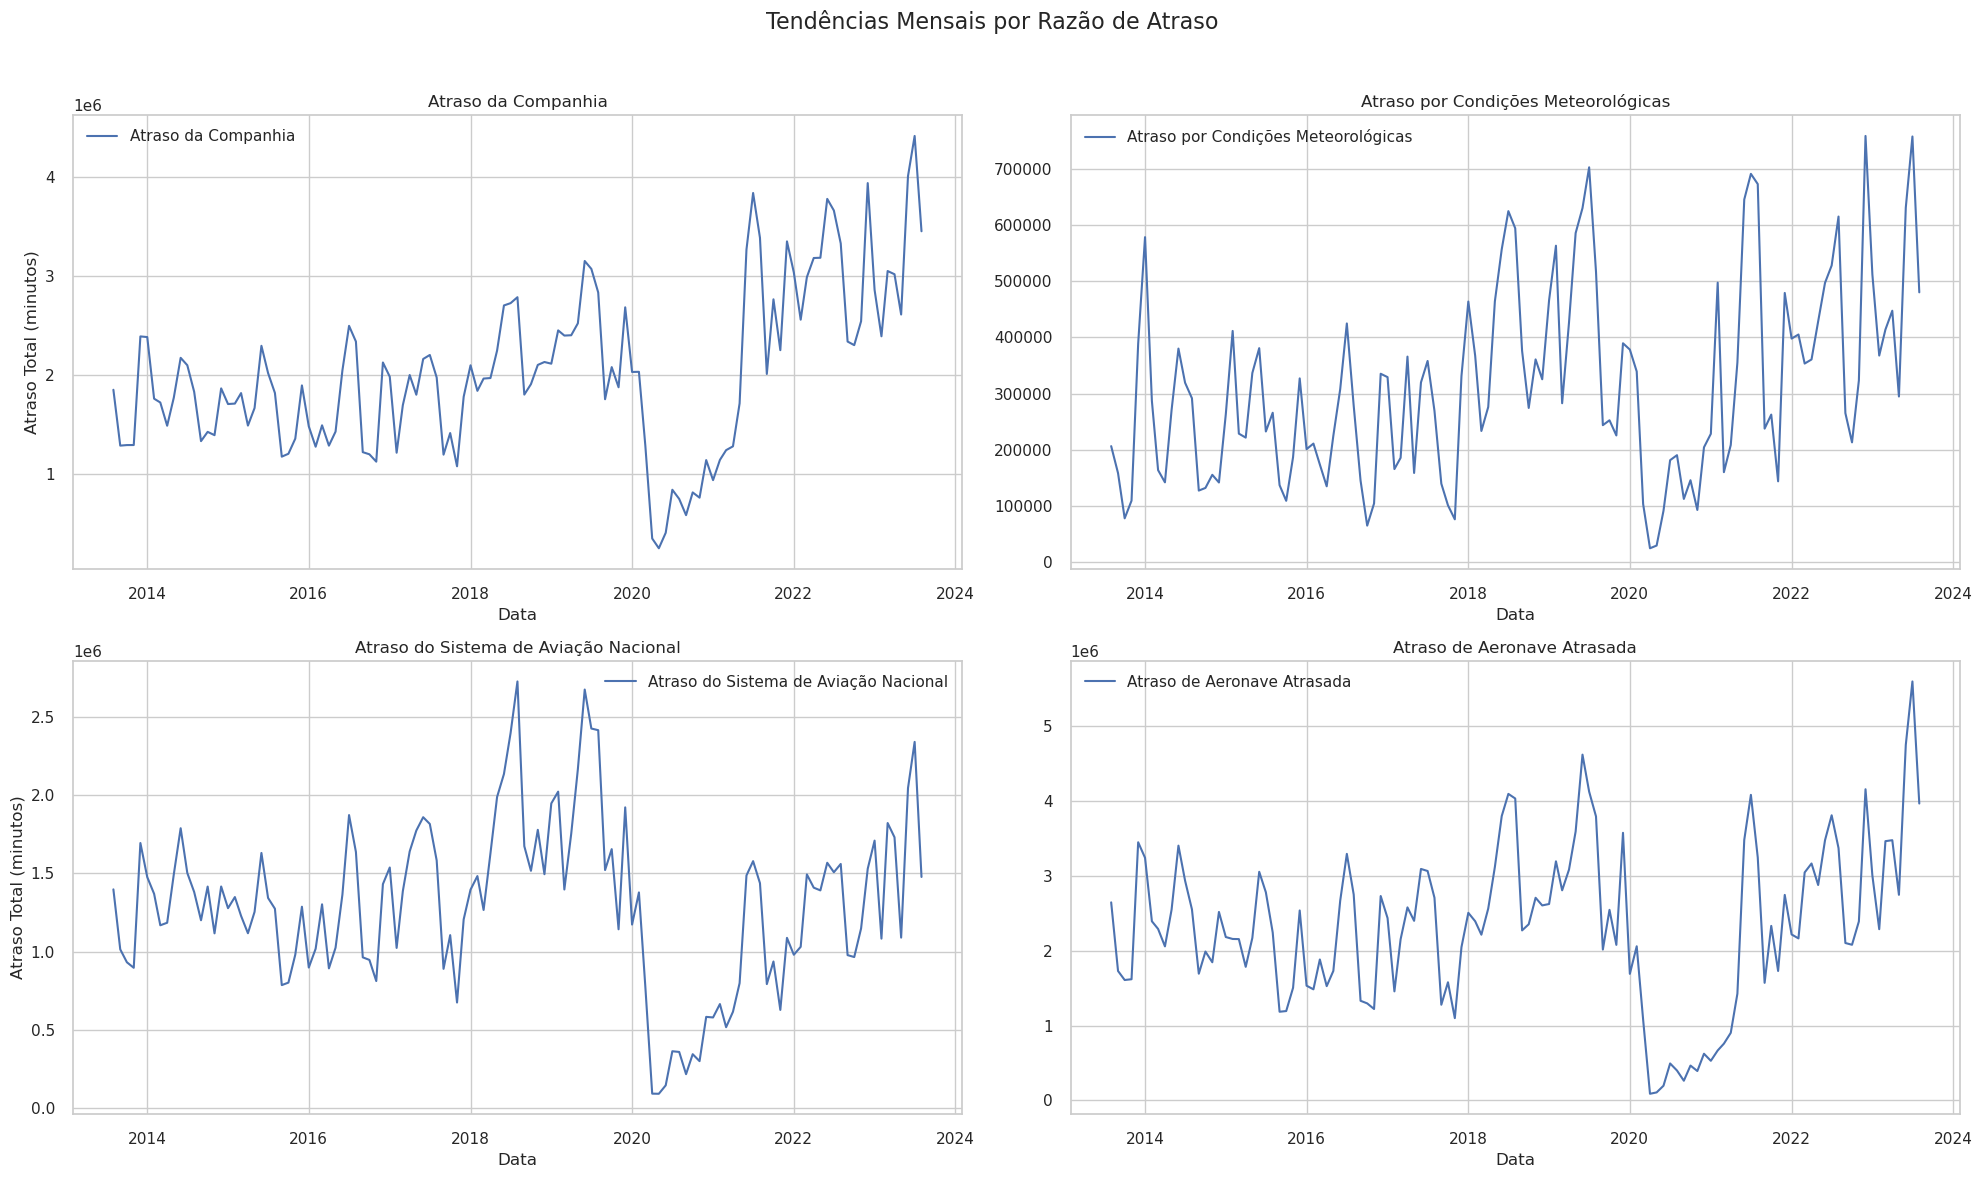

In [ ]:
delay_reasons = ['carrier_delay', 'weather_delay', 'nas_delay', 'late_aircraft_delay']
titles_pt = ['Atrasos da Companhia', 'Atrasos por Condições Meteorológicas', 'Atrasos do Sistema de Aviação Nacional', 'Atrasos de Aeronave Atrasada']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Tendências Mensais por Razão de Atraso', fontsize=16)

for i, (reason, title_pt) in enumerate(zip(delay_reasons[:4], titles_pt)):
    ax = axes[i // 2, i % 2]
    trend_data = df.groupby(['year', 'month'])[reason].sum().reset_index()
    trend_data['date'] = pd.to_datetime(trend_data[['year', 'month']].assign(day=1))
    ax.plot(trend_data['date'], trend_data[reason], label=title_pt)
    ax.set_title(title_pt)
    ax.set_xlabel('Data')
    if i % 2 == 0:
        ax.set_ylabel('Atraso Total (minutos)')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Gráfico 7: Contribuição das Causas de Atrasos

### Objetivo

Determinar a representatividade percentual de cada causa no tempo total de atraso, identificando os principais gargalos sistêmicos.

### Ações

* Somar os tempos totais de atraso:
  `carrier_delay`, `weather_delay`, `nas_delay`, `security_delay`, `late_aircraft_delay`
* Calcular a participação percentual de cada causa em relação ao atraso total acumulado ((\sum \text{arr_delay}))
* Opcionalmente, calcular a média de minutos por voo atrasado para cada causa

### Saída

Gráfico de barras verticais.

### Insight Esperado

Revelar a dinâmica operacional real: causas logísticas, como `late_aircraft_delay` e `nas_delay`, tendem a representar a maior parcela do tempo perdido, superando fatores climáticos percebidos pelo público.

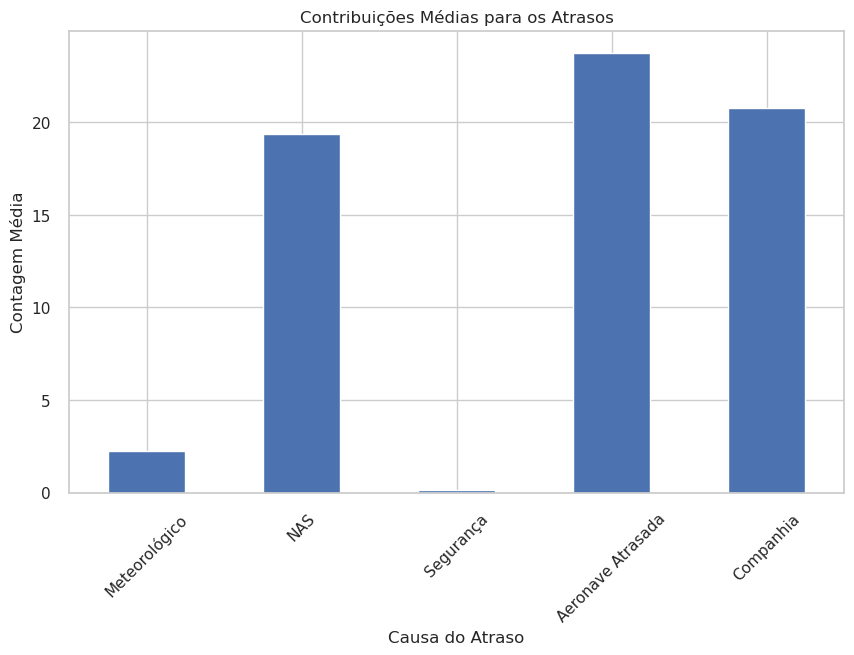

In [14]:
delay_factors = df[['weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'carrier_ct']].mean()
delay_factors_labels_pt = {
    'weather_ct': 'Meteorológico',
    'nas_ct': 'NAS',
    'security_ct': 'Segurança',
    'late_aircraft_ct': 'Aeronave Atrasada',
    'carrier_ct': 'Companhia'
}
delay_factors = delay_factors.rename(index=delay_factors_labels_pt)

plt.figure(figsize=(10, 6))
delay_factors.plot(kind='bar')
plt.title('Contribuições Médias para os Atrasos')
plt.xlabel('Causa do Atraso')
plt.ylabel('Contagem Média')
plt.xticks(rotation=45)
plt.show()

## Gráfico 8: Distribuição de Features Numéricas


### Objetivo
Caracterizar o comportamento estatístico dos atrasos, validando a hipótese de distribuição log-normal e identificando a severidade de eventos extremos (outliers).

### Ações
- **Filtragem crítica**:
  - Gerar visualizações considerando apenas `arr_delay > 0` ou `arr_delay > 15`

- **Comparação entre causas**:
  - Plotar histogramas *ridgeline plots* das principais causas:
    `carrier_delay`, `weather_delay`, `nas_delay`, `security_delay`, `late_aircraft_delay`

### Saída
Painel analítico contendo:
- Histogramas com curva de densidade (KDE)


### Insight Esperado
- **Frequência vs. severidade**: Identificar causas raras porém severas (ex: `security_delay`) versus causas frequentes com menor impacto individual  




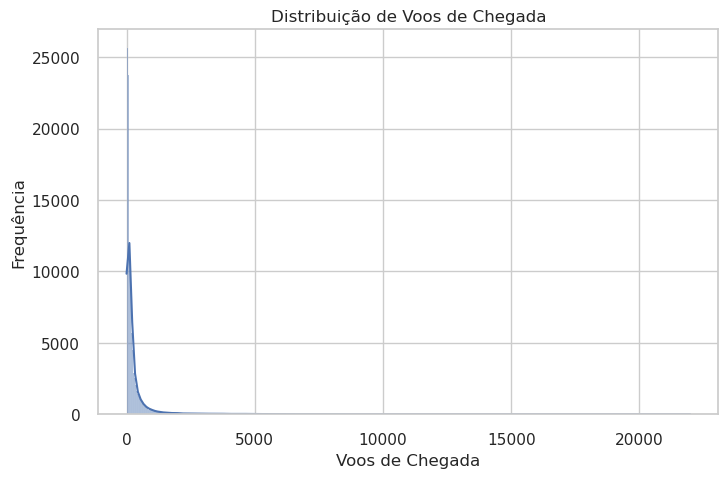

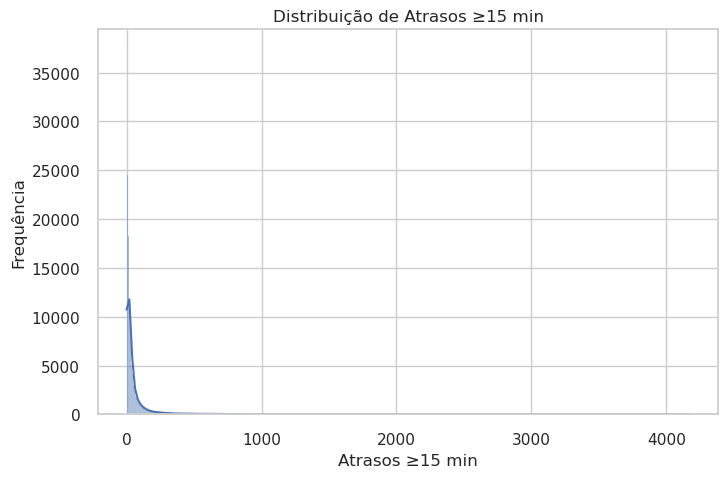

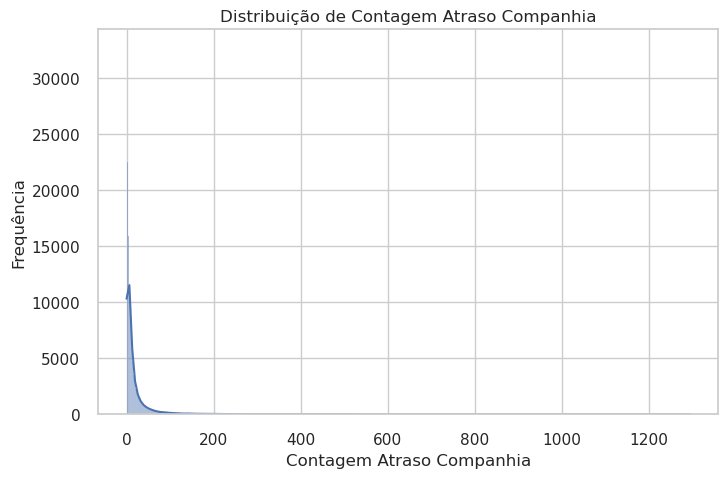

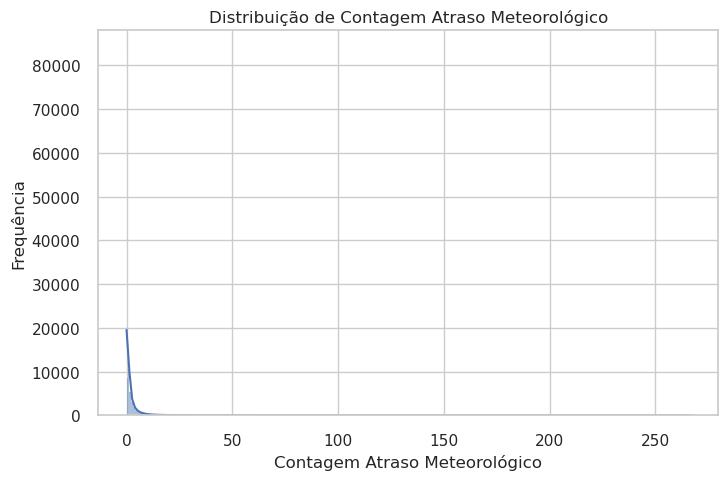

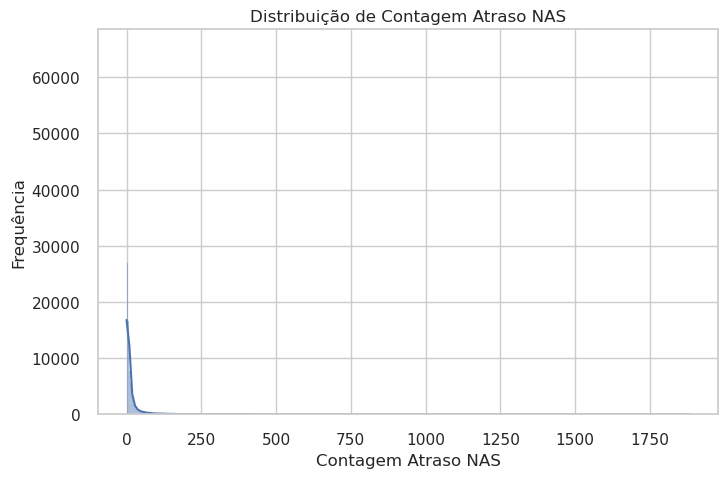

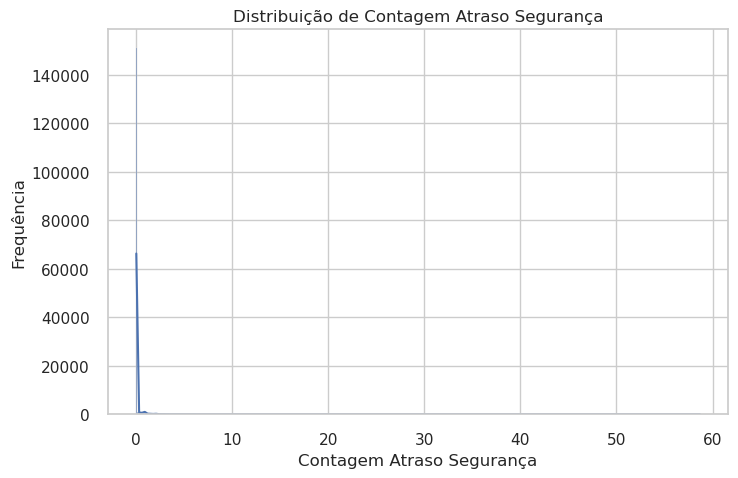

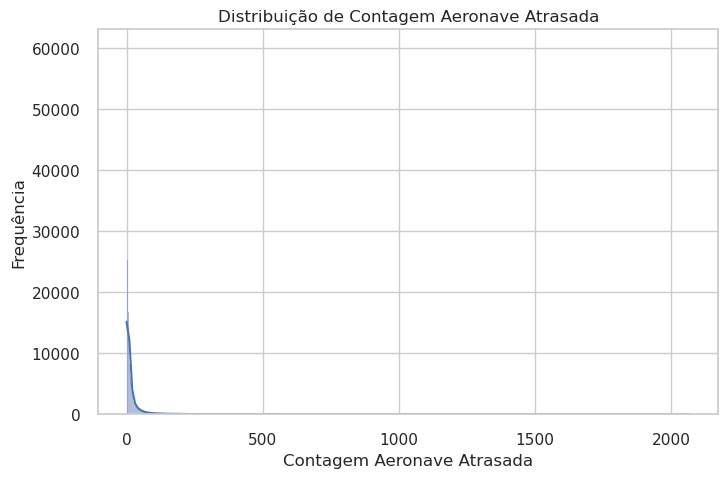

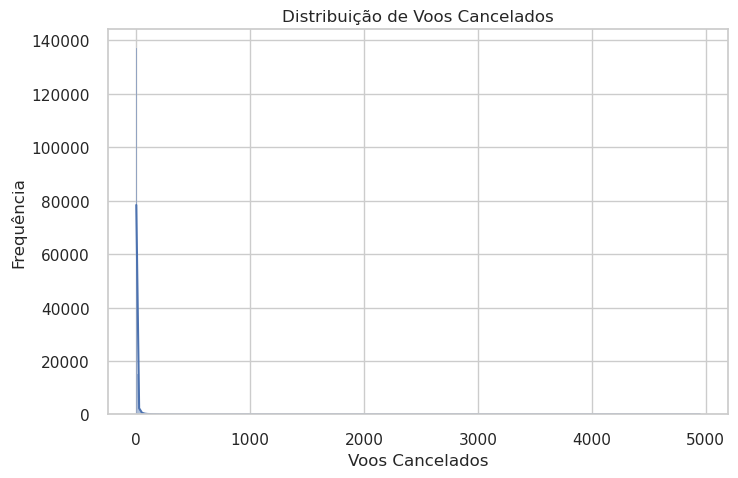

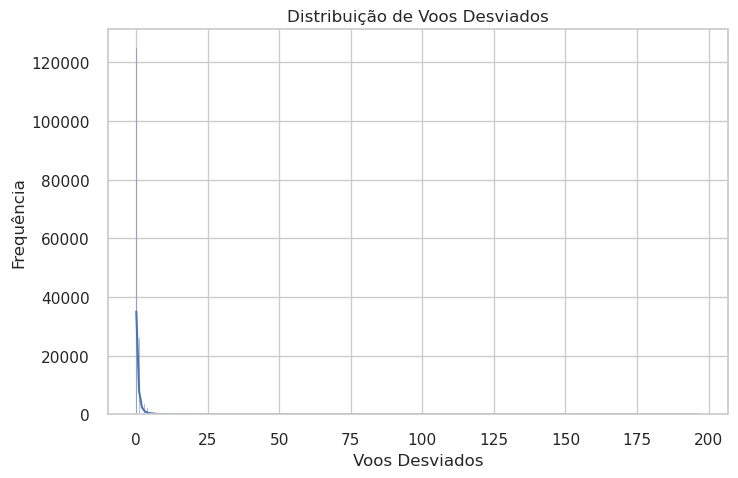

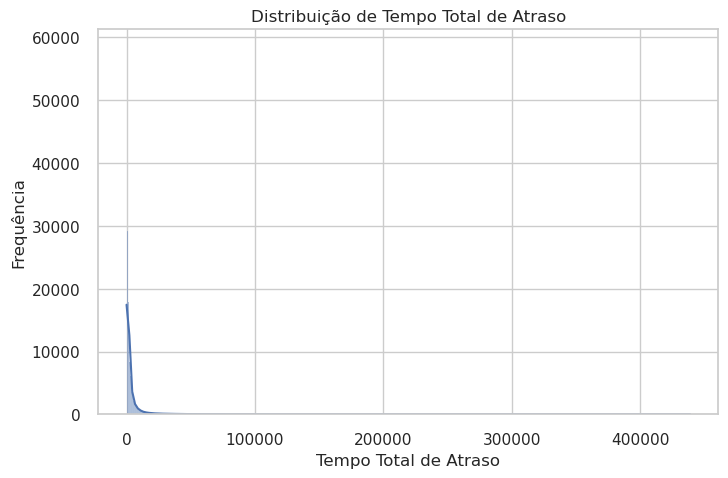

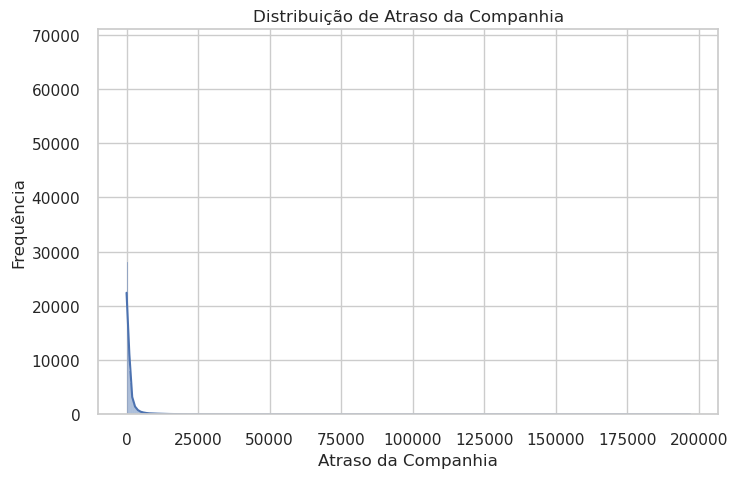

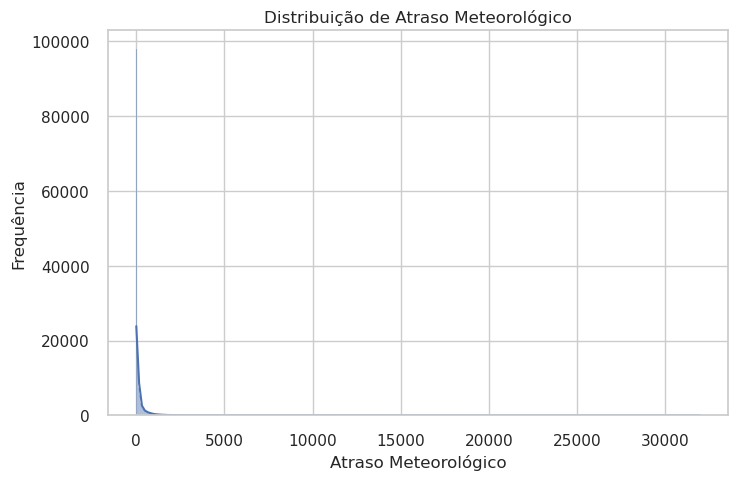

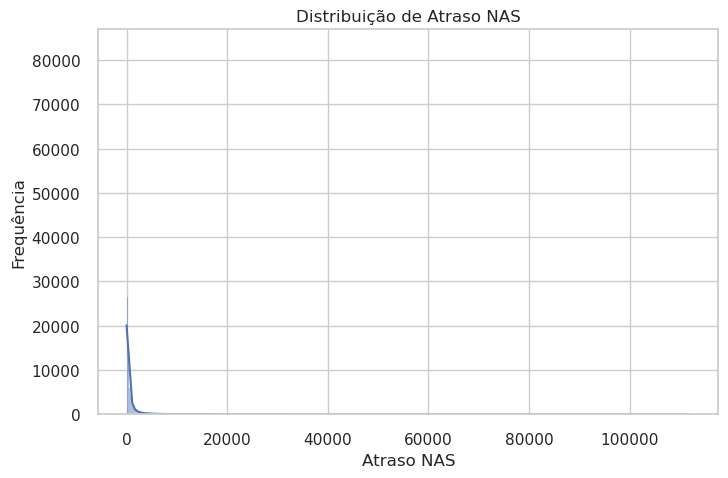

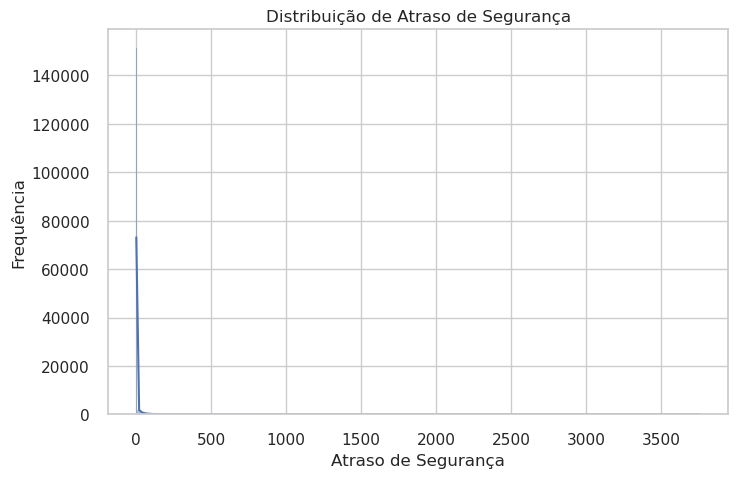

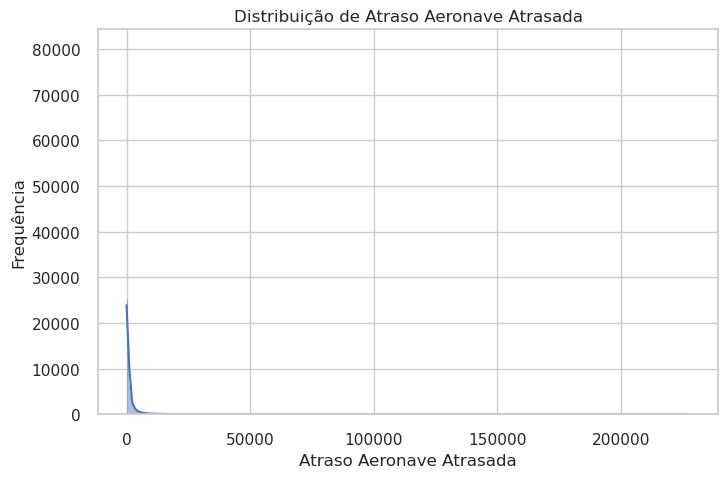

In [10]:
numeric_features = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
                    'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
                    'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
                    'security_delay', 'late_aircraft_delay']

feature_names_pt = {
    'arr_flights': 'Voos de Chegada',
    'arr_del15': 'Atrasos ≥15 min',
    'carrier_ct': 'Contagem Atraso Companhia',
    'weather_ct': 'Contagem Atraso Meteorológico',
    'nas_ct': 'Contagem Atraso NAS',
    'security_ct': 'Contagem Atraso Segurança',
    'late_aircraft_ct': 'Contagem Aeronave Atrasada',
    'arr_cancelled': 'Voos Cancelados',
    'arr_diverted': 'Voos Desviados',
    'arr_delay': 'Tempo Total de Atraso',
    'carrier_delay': 'Atraso da Companhia',
    'weather_delay': 'Atraso Meteorológico',
    'nas_delay': 'Atraso NAS',
    'security_delay': 'Atraso de Segurança',
    'late_aircraft_delay': 'Atraso Aeronave Atrasada'
}

for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribuição de {feature_names_pt[feature]}')
    plt.xlabel(feature_names_pt[feature])
    plt.ylabel('Frequência')
    plt.show()

## Gráfico 9: Top Features Categóricas

### Objetivo

Identificar companhias aéreas e aeroportos que concentram o maior volume de operações e atrasos.

### Ações

* **Companhias**: agrupar por `carrier_name`, somar `arr_del15` e `arr_flights`, selecionar o Top 15
* **Aeroportos**: agrupar por `airport_name`, somar `arr_del15` e `arr_flights`, selecionar o Top 15

### Saída

Dois gráficos de barras horizontais:

* Top 15 Companhias com Mais Atrasos
* Top 15 Aeroportos com Mais Atrasos

### Insight Esperado

Confirmar a concentração dos atrasos em grandes hubs e distinguir alta exposição operacional de problemas crônicos de performance.

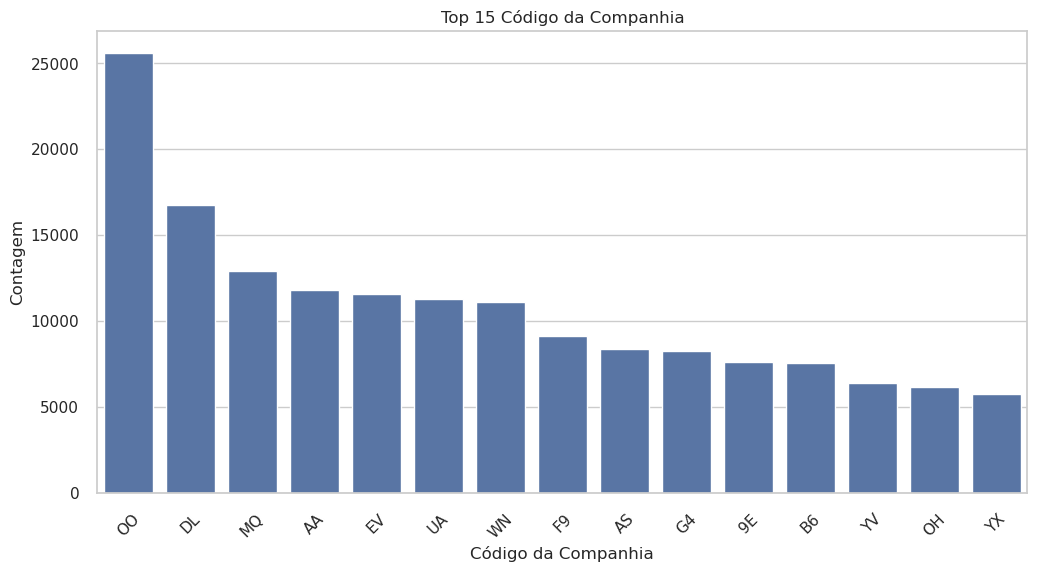

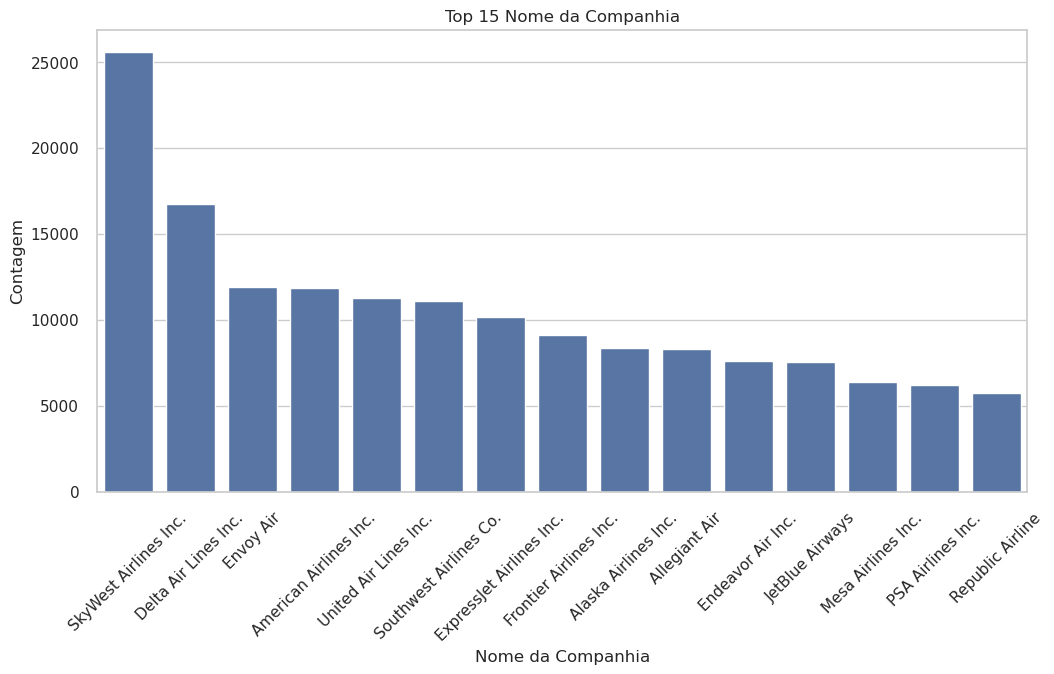

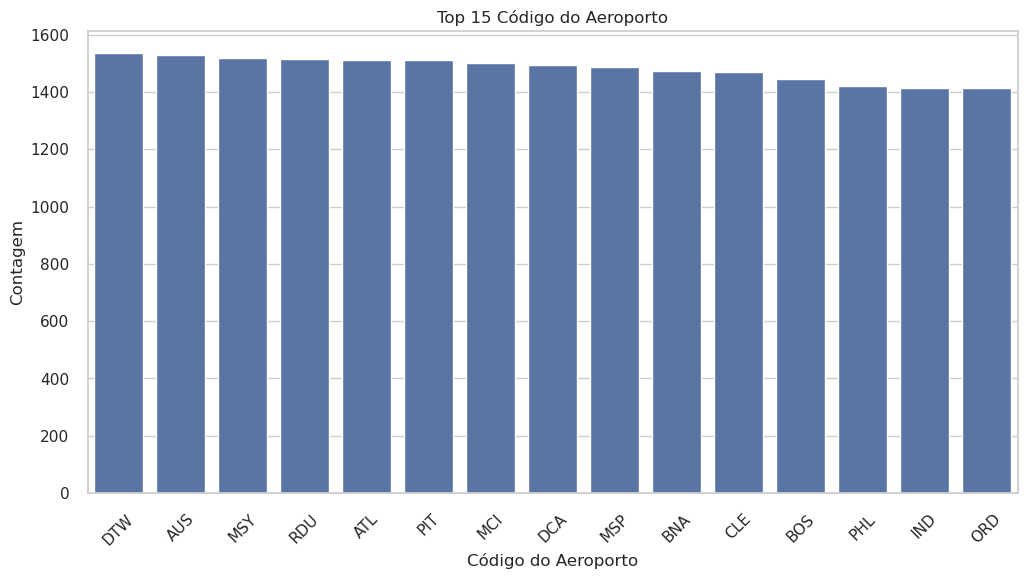

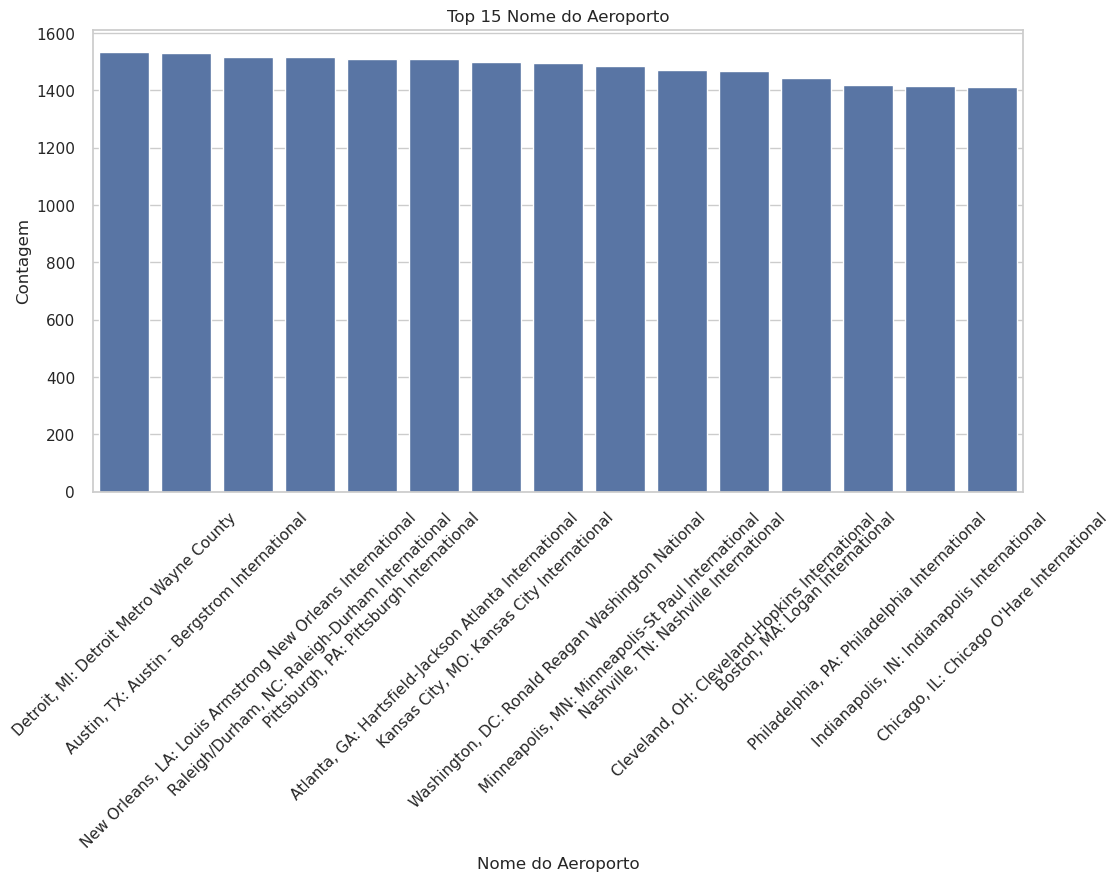

In [11]:
categorical_features = ['carrier', 'carrier_name', 'airport', 'airport_name']
categorical_names_pt = {
    'carrier': 'Código da Companhia',
    'carrier_name': 'Nome da Companhia',
    'airport': 'Código do Aeroporto',
    'airport_name': 'Nome do Aeroporto'
}

for feature in categorical_features:
    top_categories = df[feature].value_counts().nlargest(15)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_categories.index, y=top_categories.values)
    plt.title(f'Top 15 {categorical_names_pt[feature]}')
    plt.xlabel(categorical_names_pt[feature])
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.show()

## Gráfico 10: Tendência de Voos de Chegada ao Longo do Tempo

### Objetivo

Monitorar a evolução da demanda aérea e da capacidade operacional ao longo do tempo.

### Ações

* Agrupar os dados por `year` e `month`
* Somar `arr_flights` para cada período

### Saída

Gráfico de linha temporal com o volume total de voos no eixo Y.

### Insight Esperado

Visualizar choques sistêmicos e identificar padrões de recuperação e sazonalidade da demanda.

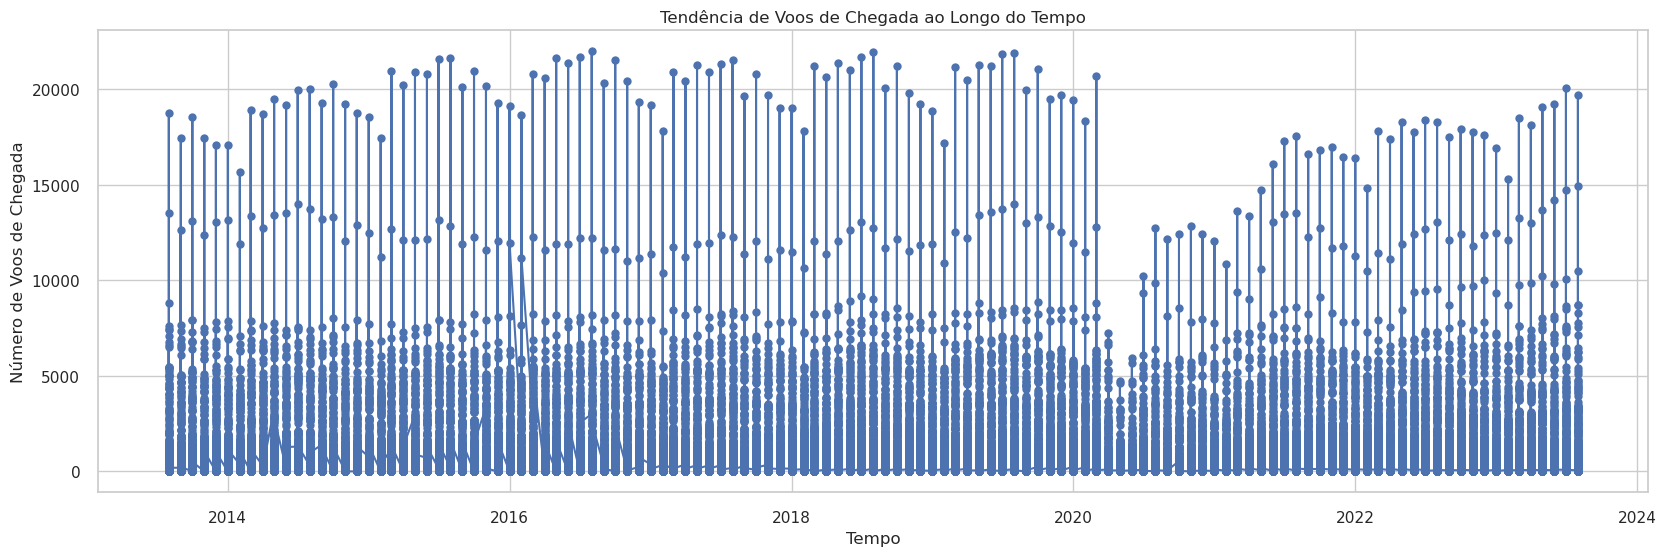

In [3]:
df_temp = df.copy()
df_temp = df_temp.set_index('date')

plt.figure(figsize=(20, 6))
plt.plot(df_temp['arr_flights'], marker='o', linestyle='-')
plt.title('Tendência de Voos de Chegada ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('Número de Voos de Chegada')
plt.show()

## Gráfico 11: Soma Mensal de Voos de Chegada

### Objetivo

Identificar padrões de evolução mensal do volume total de voos de chegada ao longo de aproximadamente uma década, permitindo identificar tendências de longo prazo, choques sistêmicos e padrões sazonais.

### Ações

* Agrupar os dados por `month`
* Somar `arr_flights` para cada mês

### Saída

Gráfico de linhas verticais representando o volume histórico total de voos por mês.

### Insight Esperado

Evidenciar picos de alta temporada e períodos de baixa demanda, facilitando análises de capacidade e correlação com atrasos.


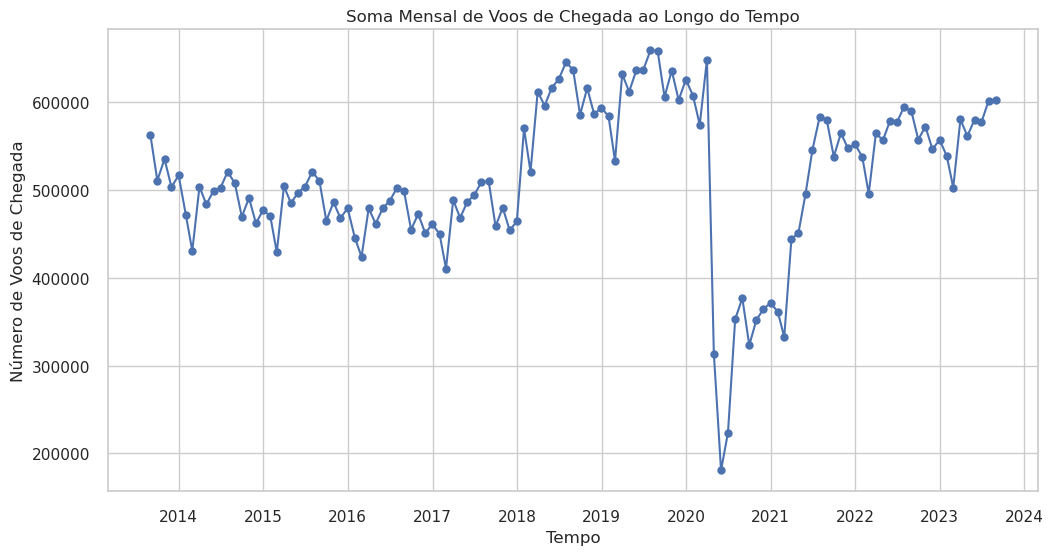

In [3]:
df_temp = df.copy()
df_temp = df_temp.set_index('date')
monthly_df = df_temp.resample('ME').sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_df['arr_flights'], marker='o', linestyle='-')
plt.title('Soma Mensal de Voos de Chegada ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('Número de Voos de Chegada')
plt.show()

## Gráfico 12: Soma Anual de Voos de Chegada

### Objetivo

Identificar padrões de evolução anual do volume total de voos de chegada ao longo de aproximadamente uma década, permitindo identificar tendências de longo prazo, choques sistêmicos e padrões sazonais.

### Ações

* Agrupar os dados por `year`
* Somar `arr_flights` para cada ano.

### Saída

Gráfico de linhas verticais representando o volume histórico total de voos por ano.

### Insight Esperado

Evidenciar picos de alta temporada e períodos de baixa demanda, facilitando análises de capacidade e correlação com atrasos, mas agora correlacionado deretamente com os anos.

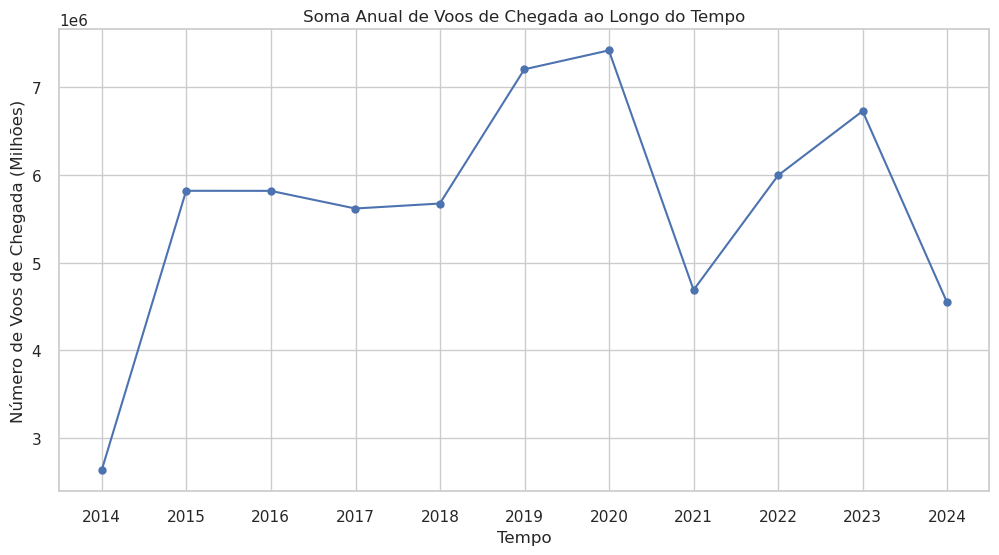

In [6]:
df_temp = df.copy()
df_temp = df_temp.set_index('date')
yearly_df = df_temp.resample('YE').sum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_df['arr_flights'], marker='o', linestyle='-')
plt.title('Soma Anual de Voos de Chegada ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('Número de Voos de Chegada (Milhões)')
plt.show()

## Gráfico 13: Decomposição Sazonal

### Objetivo
Decompor a série temporal de atrasos em três componentes fundamentais — **tendência**, **sazonalidade** e **resíduo** — para separar mudanças estruturais de variações esperadas ao longo do tempo.

### Ações
- **Preparação dos dados**:
  - Agregar `arr_delay` (soma de minutos)

### Saída
Painel vertical com quatro gráficos compartilhando o eixo temporal:
- **Original**: Série temporal bruta
- **Trend (Tendência)**: Curva suavizada indicando a evolução estrutural do desempenho
- **Seasonal (Sazonalidade)**: Padrão anual recorrente (ciclo de 12 meses)
- **Resid (Resíduo)**: Ruído e eventos extraordinários não explicados pelos demais componentes

### Insight Esperado
- **Validação da recuperação**: Avaliar se a tendência indica estabilização ou deterioração da performance operacional  
- **Detecção de anomalias**: Identificar picos nos resíduos associados a eventos atípicos (ex: início da pandemia, falhas sistêmicas, greves), direcionando investigações de causa-raiz


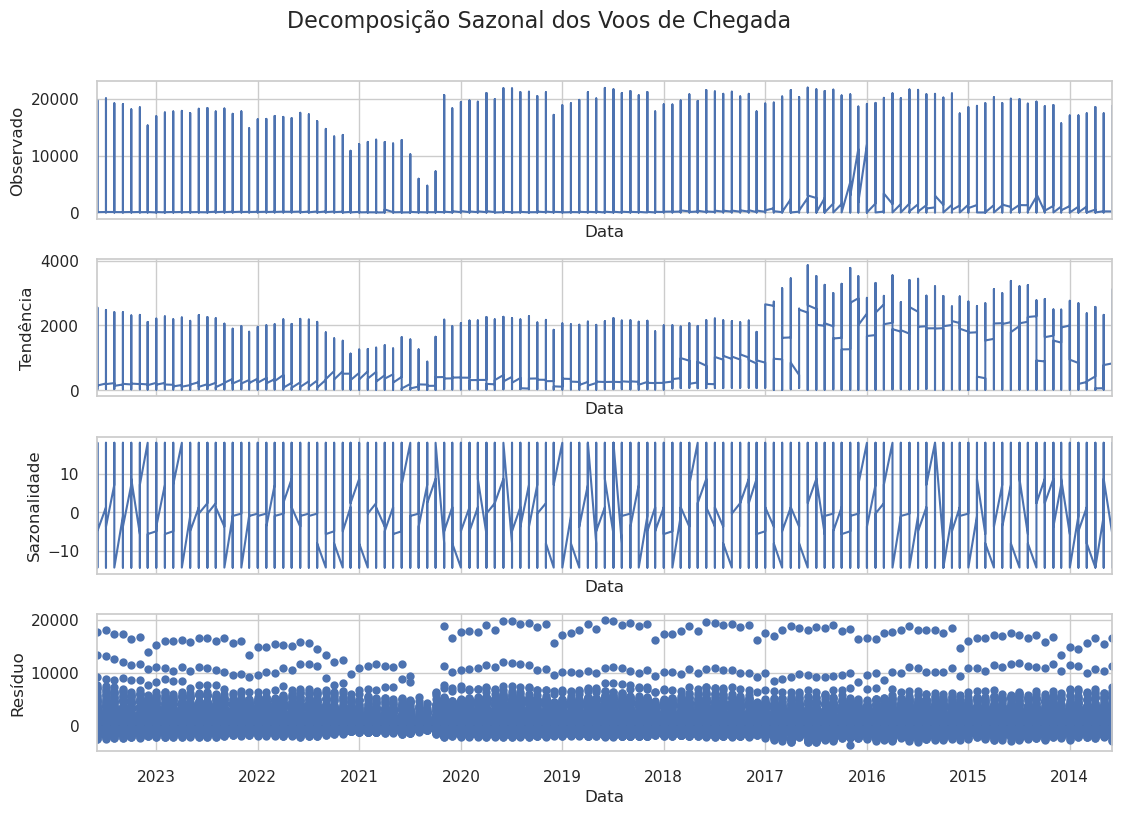

In [8]:
df_temp = df.copy()
df_temp = df_temp.set_index('date')
df_temp['arr_flights'] = df_temp['arr_flights'].fillna(df_temp['arr_flights'].median())

result = seasonal_decompose(df_temp['arr_flights'], model='additive', period=12)
fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Decomposição Sazonal dos Voos de Chegada', fontsize=16, y=1.02)

axes = fig.get_axes()
axes[0].set_ylabel('Observado')
axes[0].set_title('')
axes[1].set_ylabel('Tendência')
axes[1].set_title('')
axes[2].set_ylabel('Sazonalidade')
axes[2].set_title('')
axes[3].set_ylabel('Resíduo')
axes[3].set_title('')

for ax in axes:
    ax.set_xlabel('Data')

plt.show()